
<div align='center'><font size="6" color="red"> Misinformation is one of the biggest issues in today's society</font></div>
<div align='center'><font size="4" color="red">And Fake news is a real problem

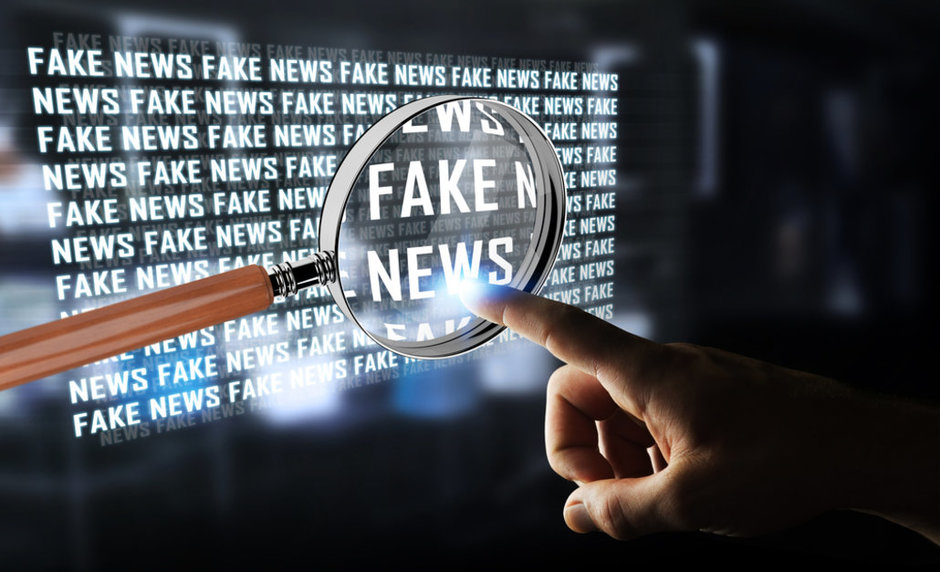

<hr>

# Problem Statement

We have 2 datasets with Real News data and Fake News data. Each dataset has around 22000 articles. As we merge both, we have around 45000 articles of real and fake. The aim is to build a model to correctly predict if a news is real or fake.

# Table of Contents

1. [Import Packages](#import-packages)
2. [Read Data](#read-data)
    * [Create Target based on Real and Fake data](#create-target)
    * [Concat both real and fake data](#concat-data)
3. [Data Analysis](#data-analysis)
    * [Missing value Treatment](#treat-missing-value)
    * [Merge Title and Text data](#merge-title-text)
4. [Data Cleaning](#data-cleaning)
    * [Preprocessing Text to get Stemmed and Lemmatized Corpus](#Preprocess-text)
    * [WordCloud for label=1 -- Real News](#word-cloud-label-1)
    * [WordCloud for label=0 -- Fake News](#word-cloud-label-0)
5. [Classification models using CountVectorizer and TFIDF Vectorizer](#create-models)
    * [Using CountVectorizer and TFIDF Vectorizer with stemmed text](#counttfidf-stemmed)
    * [Using CountVectorizer and TFIDF Vectorizer with lemmatized text](#counttfidf-lemmatized)
6. [LSTM model using One Hot vector](#one-hot-vector-lstm)
    * [Using One hot representation and Stemmed Text](#one-hot-stemmed)
    * [Evaluate model](#stemmed-evaluate)
    * [Using One hot representation and Lemmatized Text](#one-hot-lemmatized)
    * [Evaluate model](#lemmatized-evaluate)
7. [Conclusion](#conclusion)



# Import Packages
<a id = "import-packages"></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import History

from wordcloud import WordCloud, STOPWORDS

# Read Data
<a id = "read-data"></a>

In [ ]:
real = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
real.head()

In [ ]:
fake = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")
fake.head()

**Create Target based on Real and Fake data**
<a id="create-target"></a>

In [ ]:
real['Category'] = 1
fake['Category'] = 0

In [ ]:
print(real.shape)
real.head()

In [ ]:
print(fake.shape)
fake.head()

**Concat both real and fake data**
<a id = "concat-data"></a>

In [ ]:
dataset = pd.concat([real, fake]).reset_index(drop=True)

In [ ]:
print(dataset.shape)
dataset.head()

# Data Analysis
<a id = "data-analysis"></a>

**Missing value Treatment**
<a id = "treat-missing-value"></a>

In [ ]:
dataset.isnull().sum()

As there is no missing value in the dataset, so we we can work directly on title and text columns

**Merge Title and Text data**
<a id = "merge-title-text"></a>

In [ ]:
dataset['final_text'] = dataset['title'] + dataset['text']
dataset['final_text'].head()

In [ ]:
dataset['Category'].value_counts()

In [ ]:
dataset[['Category','subject','final_text']].groupby(['Category','subject']).count()

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x= "subject", hue = "Category", data=dataset)

# Data Cleaning
<a id = "data-cleaning"></a>

**Preprocessing Text to get Stemmed and Lemmatized Corpus**
<a id = "Preprocess-text"></a>

In this step we will clean the data that will be used for training. The cleaning will involve these steps-
1. Removing all the extra information like brackets, any kind of puctuations - commas, apostrophes, quotes, question marks, and more.
2. Remove all the numeric text, urls
3. Remove all the stop words like - just, and, or, but, if
4. Convert all the remaining text in the lower case, separated by space
5. Generate stemmed text
6. Generate lemmatized text

In [ ]:
porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
stemmed_text = []
lemmatized_text = []
final_text_result = []
for text in dataset['final_text']:
    result = re.sub('[^a-zA-Z]', ' ', text)
    result = result.lower()
    result = result.split()
    result = [r for r in result if r not in set(stopwords.words('english'))]
    stemmed_result = [porter_stemmer.stem(r) for r in result]
    stemmed_text.append(" ".join(stemmed_result))
    lemmatized_result = [lemmatizer.lemmatize(r) for r in result]
    lemmatized_text.append(" ".join(lemmatized_result))

In [ ]:
print(len(stemmed_text))
print(len(lemmatized_text))

**WordCloud for label=1 -- Real News**
<a id = "word-cloud-label-1"></a>

In [ ]:
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(dataset[dataset.Category==1].final_text))
plt.imshow(wc, interpolation="bilinear")

**WordCloud for label=0 -- Fake News**
<a id = "word-cloud-label-0"></a>

In [ ]:
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(dataset[dataset.Category==0].final_text))
plt.imshow(wc, interpolation="bilinear")

# Classification models using CountVectorizer and TFIDF Vectorizer
<a id = "create-models"></a>


In [ ]:
def get_prediction(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n", cm)
    print("Classification Report: \n", classification_report(y_test, y_pred))

Below I am creating classification models in 2 steps-
1. Using stemmed text and both Count Vectorizer and TFIDF Vectorizer
1. Using lemmatized text and both Count Vectorizer and TFIDF Vectorizer

**Using CountVectorizer and TFIDF Vectorizer with stemmed text**
<a id="counttfidf-stemmed"></a>

In [ ]:
print("******USING STEMMED TEXT********")
X_train, X_test, y_train, y_test = train_test_split(stemmed_text, dataset['Category'], test_size = 0.3, random_state= 0)
classifiers = [LogisticRegression(), SGDClassifier(), MultinomialNB(), BernoulliNB(), LinearSVC(),
              KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(), GradientBoostingClassifier(), 
               RandomForestClassifier(), XGBClassifier()]
for classifier in classifiers:
    print("\n\n", classifier)
    print("***********Usng Count Vectorizer****************")
    get_prediction(CountVectorizer(), classifier, X_train, X_test, y_train, y_test)
    print("***********Usng TFIDF Vectorizer****************")
    get_prediction(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)

**Using CountVectorizer and TFIDF Vectorizer with lemmatized text**
<a id="counttfidf-lemmatized"></a>

In [ ]:
print("******USING LEMMATIZED TEXT********")
X_train, X_test, y_train, y_test = train_test_split(lemmatized_text, dataset['Category'], test_size = 0.3, random_state= 0)
classifiers = [LogisticRegression(), SGDClassifier(), MultinomialNB(), BernoulliNB(), LinearSVC(),
              KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(), GradientBoostingClassifier(), 
               RandomForestClassifier(), XGBClassifier()]
for classifier in classifiers:
    print("\n\n", classifier)
    print("***********Usng Count Vectorizer****************")
    get_prediction(CountVectorizer(), classifier, X_train, X_test, y_train, y_test)
    print("***********Usng TFIDF Vectorizer****************")
    get_prediction(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)

After doing Predictive analysis above using both stemmed text and lemmatized text with Count Vectorizer and TFIDF Vectorizer, we see that the XGB Classifier is giving best results with lemmatized texts and Count Vectorizer with accuracy score of 99.78%

# LSTM model using One Hot vector 
<a id ="one-hot-vector-lstm"></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

**Using One hot representation and Stemmed Text**
<a id = "one-hot-stemmed"></a>

In [ ]:
voc_size = 5000
onehot_stemmed_text = [one_hot(word, voc_size) for word in stemmed_text]
print(len(onehot_stemmed_text))
onehot_stemmed_text[0]

In [ ]:
sent_length = 400
embedded_text = pad_sequences(onehot_stemmed_text, padding='pre', maxlen=sent_length)
print(embedded_text)

In [ ]:
embedding_vector_features = 600
model1 = Sequential()
model1.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model1.add(LSTM(100))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model1.summary()

In [ ]:
X_final = np.array(embedded_text)
y_final = dataset['Category']

In [ ]:
X_final.shape,y_final.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.3, random_state = 0)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')

In [ ]:
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size = 256, callbacks=([reduce_lr, early_stop]))

**Evaluate model**
<a id = "stemmed-evaluate"></a>

In [ ]:
y_pred = model1.predict_classes(X_test)
print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

In [ ]:
print("Classification Report: \n", classification_report(y_test, y_pred))

**Using One hot representation and Lemmatized Text**
<a id = "one-hot-lemmatized"></a>

In [ ]:
voc_size = 5000
onehot_lemmatized_text = [one_hot(word, voc_size) for word in lemmatized_text]
print(len(onehot_lemmatized_text))
onehot_lemmatized_text[0]

In [ ]:
sent_length = 400
embedded_text = pad_sequences(onehot_lemmatized_text, padding='pre', maxlen=sent_length)
print(embedded_text)

In [ ]:
embedding_vector_features = 600
model2 = Sequential()
model2.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model2.add(LSTM(100))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model2.summary()

In [ ]:
X_final = np.array(embedded_text)
y_final = dataset['Category']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.3, random_state = 0)

In [ ]:
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size = 256, callbacks=([reduce_lr, early_stop]))

**Evaluate model**
<a id = "lemmatized-evaluate"></a>

In [ ]:
y_pred = model2.predict_classes(X_test)
print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

In [ ]:
print("Classification Report: \n", classification_report(y_test, y_pred))

With One hot vector and stemmed text LSTM model is giving 98.7 % accuracy.

# Conclusion
<a id="conclusion"></a>

Till this point, we are not getting any benefit in accuracy using LSTM model with Onehot vector. And XGBClassifier with CountVectorizer was giving better results.<br>
I will create another version of this dataset, where I will use the glove vector and bert.

**If you like the kernel please upvote.
If you have any questions/feedback feel free to comment and I will be happy to answer.
**